## NEW: ULMFiT-2 Blue-or-Red Training: 2022 Tweets

In [1]:
from fastai.text.all import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from ideology_utils import *

#### Grab Congressional tweets for each week and create a dataframe

In [4]:
path = Path()
path_22 = path/'tweets/'

In [5]:
df = pd.concat(map(tweets2df, path_22.rglob("tweets-congress*/*")))

#### Label each tweet according by the handle of the legislator

In [6]:
df = label_tweets_of_legislators(df)
df = df[['text','party']]

#### Preprocess each of the tweets

In [7]:
df = preprocess_tweets(df)

#### Shuffle and create Training (which Validation) and Testing Sets

In [8]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
n_tr = Int(.9*(len(df)))
n_tr

482338

In [10]:
df_train, df_test = df[:n_tr], df[n_tr+1:]

### Fine-tuning a language model on Congressional Tweets from 2022

In [11]:
dls_lm = TextDataLoaders.from_df(df_train, is_lm=True, valid_pct=0.1, bs=128)

In [12]:
dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos xxmaj the xxmaj biden xxmaj administration has proposed an amendment to the xxmaj world xxmaj health xxmaj organization ’s “ global xxmaj pandemic xxmaj treaty ” that could grant the xxup who the authority to declare & & define public health emergencies . xxmaj letting xxup who bureaucrats set health & & lockdown policies in xxmaj america ? xxmaj no chanc xxbos i am honored to celebrate this # hispanicheritagemonth with,xxmaj the xxmaj biden xxmaj administration has proposed an amendment to the xxmaj world xxmaj health xxmaj organization ’s “ global xxmaj pandemic xxmaj treaty ” that could grant the xxup who the authority to declare & & define public health emergencies . xxmaj letting xxup who bureaucrats set health & & lockdown policies in xxmaj america ? xxmaj no chanc xxbos i am honored to celebrate this # hispanicheritagemonth with my
1,for a new affordable housing unit in the xxmaj bronx pioneered by @user xxmaj housing is a human right and housing is healthcare . http xxbos xxmaj president xxmaj biden ’s decision to help provide struggling nations with access to vaccines will help save lives and help the world overcome this pandemic . xxmaj this is the type of xxmaj american leadership that the world has been desperate to see once again,a new affordable housing unit in the xxmaj bronx pioneered by @user xxmaj housing is a human right and housing is healthcare . http xxbos xxmaj president xxmaj biden ’s decision to help provide struggling nations with access to vaccines will help save lives and help the world overcome this pandemic . xxmaj this is the type of xxmaj american leadership that the world has been desperate to see once again .
2,xxmaj infrastructure xxmaj law & & @user https : / / t.co / xxunk http xxbos xxmaj see my recent statement denouncing the xxmaj cuban dictatorship ’s crackdown on independent artists : http xxbos xxup tw : a man punched a father to the ground with his baby in the xxunk next to him . xxmaj police say the attack appeared to be random and no words were exchanged . # stopasianhate,infrastructure xxmaj law & & @user https : / / t.co / xxunk http xxbos xxmaj see my recent statement denouncing the xxmaj cuban dictatorship ’s crackdown on independent artists : http xxbos xxup tw : a man punched a father to the ground with his baby in the xxunk next to him . xxmaj police say the attack appeared to be random and no words were exchanged . # stopasianhate http
3,/ http xxbos xxmaj on xxmaj international xxmaj day xxmaj against xxmaj homophobia xxmaj biphobia and xxmaj transphobia i stand with xxmaj arizona 's xxup lgbtq+ community in their fight for xxunk deserves to live without fear of prejudice because of who they are or who they love . # xxup idahobit xxbos xxmaj the xxmaj house of xxmaj representatives must return to xxmaj washington and continue the work of the people,http xxbos xxmaj on xxmaj international xxmaj day xxmaj against xxmaj homophobia xxmaj biphobia and xxmaj transphobia i stand with xxmaj arizona 's xxup lgbtq+ community in their fight for xxunk deserves to live without fear of prejudice because of who they are or who they love . # xxup idahobit xxbos xxmaj the xxmaj house of xxmaj representatives must return to xxmaj washington and continue the work of the people to
4,am thankful to everyone who has supported me along the way especially my fantastic wife xxmaj heather . xxmaj now the real work begins for # xxup ca08 ! http xxbos xxmaj today and every day we ’re grateful for our brave law enforcement officers across xxmaj arizona . xxmaj thank you for keeping us safe and secure . # lawenforcementappreciationday xxbos xxmaj today i joined the xxmaj american xxmaj sikh xxmaj,thankful to everyone who has supported me along the way especially my fantastic wife xxmaj heather . xxmaj now the real work begins for # xxup ca08 ! http xxbos xxmaj today and every day we ’re grateful for our brave law enforcement officers across xxmaj arizona . xxmaj thank you for keepin

In [13]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

SuggestedLRs(valley=0.010964781977236271)

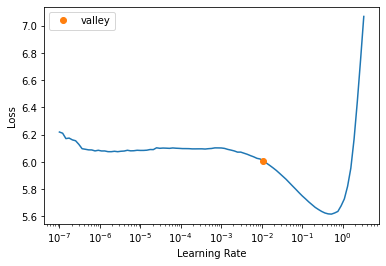

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(3, .01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.905363,3.572006,0.350785,35.587917,36:16
1,3.831519,3.504363,0.357935,33.260235,36:17
2,3.783841,3.469825,0.361683,32.131104,36:43


In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, .01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.516998,3.336008,0.379659,28.106709,36:17
1,3.297676,3.116589,0.403593,22.569265,36:33


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, .01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.399633,3.222585,0.391779,25.092901,36:28


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
learn.save_encoder('ulmfit-lm-2022')

### Training a text classifier

In [20]:
dls_clas = TextDataLoaders.from_df(df_train, valid_pct=.2, text_col='text', label='party',           text_vocab=dls_lm.vocab, bs=128)

In [21]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [22]:
learn = learn.load_encoder('ulmfit-lm-2022') # Reuse language model

SuggestedLRs(valley=0.004365158267319202)

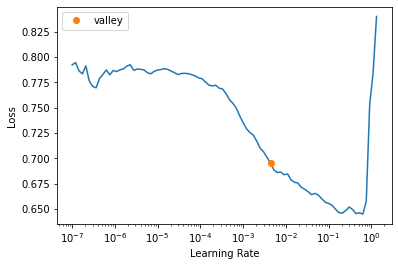

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(2, .004)

epoch,train_loss,valid_loss,accuracy,time
0,0.463908,0.426967,0.792478,01:54
1,0.438329,0.411947,0.800025,01:55


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.397489,0.375176,0.820934,02:12
1,0.370791,0.332902,0.842205,02:13
2,0.318660,0.315195,0.852271,02:13


In [26]:
learn.freeze_to(-5)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.310679,0.296565,0.863694,04:23
1,0.274837,0.267799,0.876528,04:23
2,0.208537,0.258518,0.886666,04:24
3,0.166574,0.271513,0.886967,04:23


In [27]:
learn.save("clss-fifth-2022")

Path('models/clss-fifth-2022.pth')

In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.158539,0.268893,0.887817,04:23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.144478,0.279264,0.888397,04:17
1,0.134364,0.295070,0.889392,04:22


In [35]:
learn.export("ulmfit-2022.pkl")

### Evaluate Model on Test Dataset

In [30]:
dl_test = learn.dls.test_dl(df_test, with_labels=True)

In [31]:
predicts, actuals = learn.get_preds(dl = dl_test)
predicts, actuals = np.argmax(predicts, axis=1).numpy(), actuals.numpy()

In [39]:
sum(predicts == actuals)/len(predicts)

0.891646297091038

The **89.2%** accuracy of the model predictions on the **Test Data** is nearly identical to that of the accuracy model prediction on the **Training Data.**

###  Load Model

In [33]:
path_19 = '/home/cdaniels/fastai-projects/blue-or-red/data_full'
ideology_score(Path(path_19)/"McConnellPress.csv","ulmfit-2022.pkl")

['McConnellPress', 0.85, 0.81, 1451]

In [34]:
path_22 = path/'tweets'/'tweets-congress-2022-05-24'
ideology_score(path_22/'McConnellPress.csv', "ulmfit-2022.pkl")

['McConnellPress', 1.0, 0.99, 18]